# Finding the best projection for fisheye lenses

This notebook investigates which of the different world coordinate system (WCS) projects work best for fisheye lenses.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii

The following file contains a list of matched stars, with pixel positions on the image ($x$ and $y$) columns, as well as their celestial position (`ra` and `dec`). This matched list is generated from file `2019-07-27T23:08:02.280.fits`, which is a $3096\times2080$ image. Plots of the pixel and celestial positions are given below. This image was taken with an ASI178MC using the standard ZWO lens (2.5mm F/1.2).

In [2]:
t = ascii.read("distort.dat")

(-90, 90)

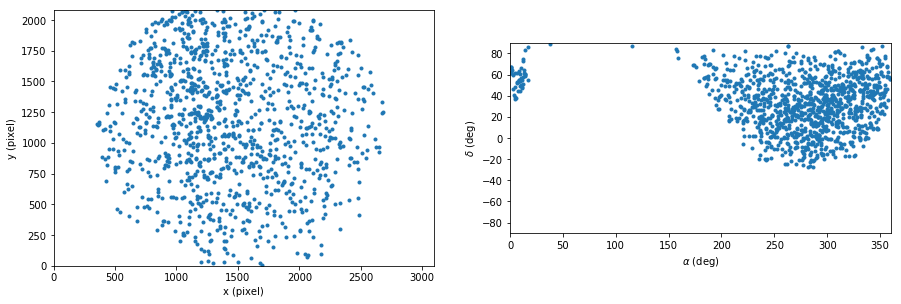

In [3]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))

ax1.plot(t["x"], t["y"], ".")
ax1.set_aspect(1.0)
ax1.set_xlabel("x (pixel)")
ax1.set_ylabel("y (pixel)")
ax1.set_xlim(0, 3096)
ax1.set_ylim(0, 2080)

ax2.plot(t["ra"], t["dec"], ".")
ax2.set_aspect(1.0)
ax2.set_xlabel(r"$\alpha$ (deg)")
ax2.set_ylabel(r"$\delta$ (deg)")
ax2.set_xlim(0, 360)
ax2.set_ylim(-90, 90)

To compute a world coordinate system (WCS), we first need to project the celestial positions around some reference point $\alpha_0$ and $\delta_0$. Similarly, the pixel position are referenced to the center of the image $x_0=1548$, $y_0=1040$. We can then set up a reference which projects the celestial positions onto a rectangular grid. Here, we use a stereographic projection (WCS code `STG`), and a transformation matrix which directly transforms $\alpha$ to $-x$ and $\delta$ to $y$, both in units of degrees.

In [4]:
ra0, dec0 = np.mean(t["ra"]), np.mean(t["dec"])
x0, y0 = 1548, 1040
dx, dy = t["x"]-x0, t["y"]-y0
print(ra0, dec0)

273.2788727528016 32.98374466971185


As the fisheye lens will have some distortion. The following polynomials model distortion as a linear transformation ($m=3$), quadratic ($m=6$), cubic ($m=10$), 4th order ($m=15$) or a 5th order ($m=21$) polynomial.

In [5]:
from astropy import wcs

In [6]:
# Polynomial model
def model(a, x, y):
    x2, y2 = x*x, y*y
    x3, y3 = x2*x, y2*y
    x4, y4 = x2*x2, y2*y2
    m = len(a)
    if m==3:
        zm = a[0]+a[1]*x+a[2]*y
    elif m==6:
        zm = a[0]+a[1]*x+a[2]*y+a[3]*x2+a[4]*x*y+a[5]*y2
    elif m==10:
        zm = a[0]+a[1]*x+a[2]*y+a[3]*x2+a[4]*x*y+a[5]*y2+a[6]*x3+a[7]*x2*y+a[8]*x*y2+a[9]*y3
    elif m==15:
        zm = a[0]+a[1]*x+a[2]*y+a[3]*x2+a[4]*x*y+a[5]*y2+a[6]*x3+a[7]*x2*y+a[8]*x*y2+a[9]*y3
        zm += a[10]*x4+a[11]*x3*y+a[12]*x2*y2+a[13]*x*y3+a[14]*y4
    elif m==21:
        zm = a[0]+a[1]*x+a[2]*y+a[3]*x2+a[4]*x*y+a[5]*y2+a[6]*x3+a[7]*x2*y+a[8]*x*y2+a[9]*y3
        zm += a[10]*x4+a[11]*x3*y+a[12]*x2*y2+a[13]*x*y3+a[14]*y4
        zm += a[15]*x3*x2+a[16]*x4*y+a[17]*x3*y2+a[18]*x2*y3+a[19]*x*y4+a[20]*y3*y2
    return zm

In [7]:
# Residual function
def residual(a, x, y, z):
    return z-model(a, x, y)

In [8]:
from scipy import optimize

For some of the more logical WCS projections we plot the residuals after fitting polynomials of different orders to see which projection minimizes the residuals with the lowest polynomial order.

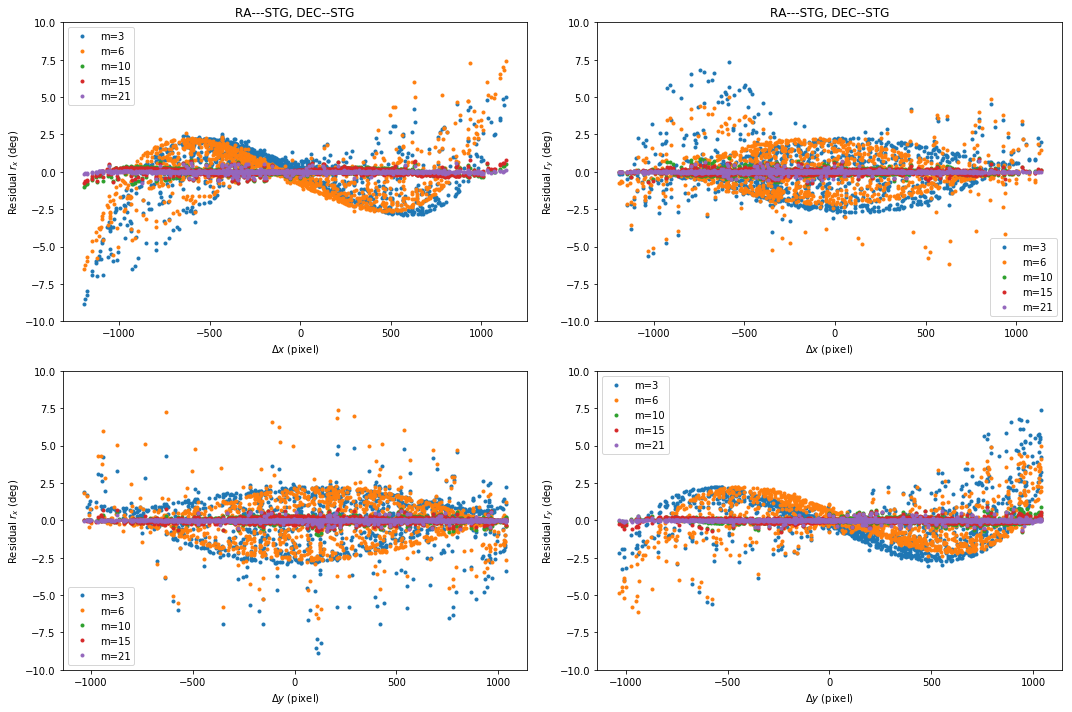

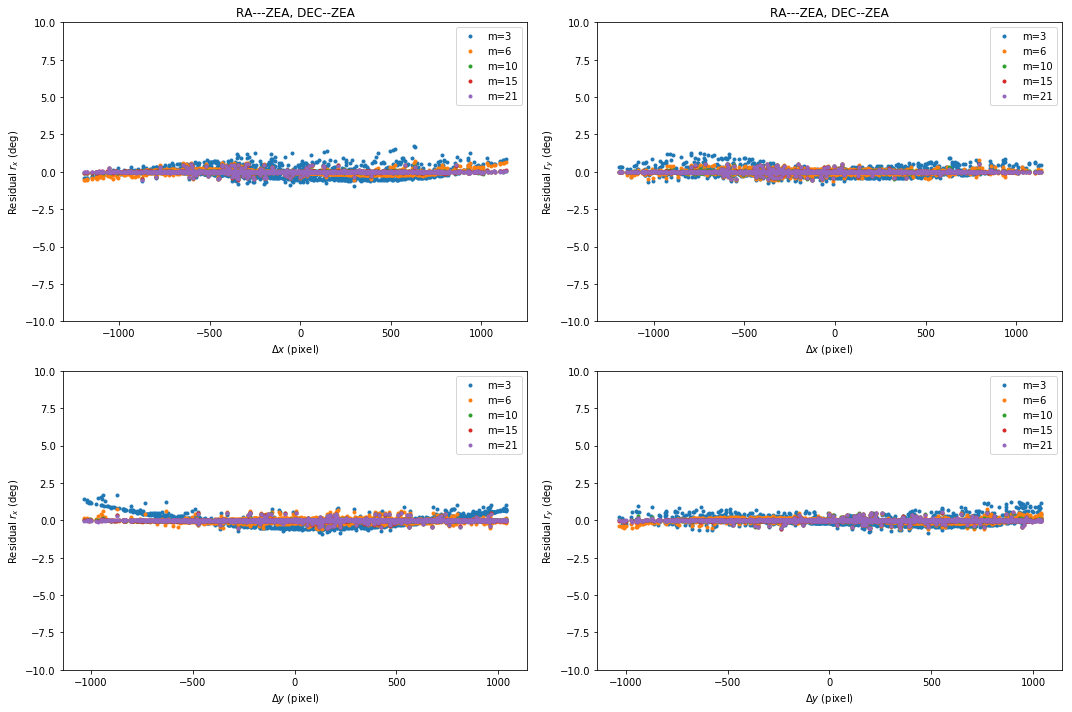

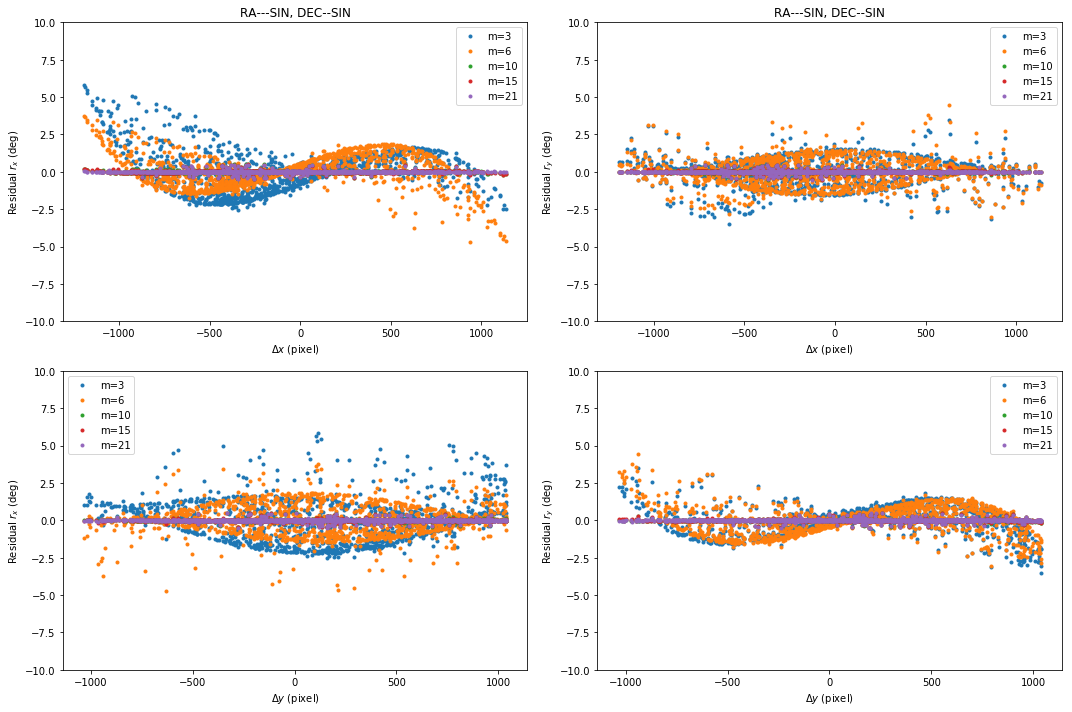

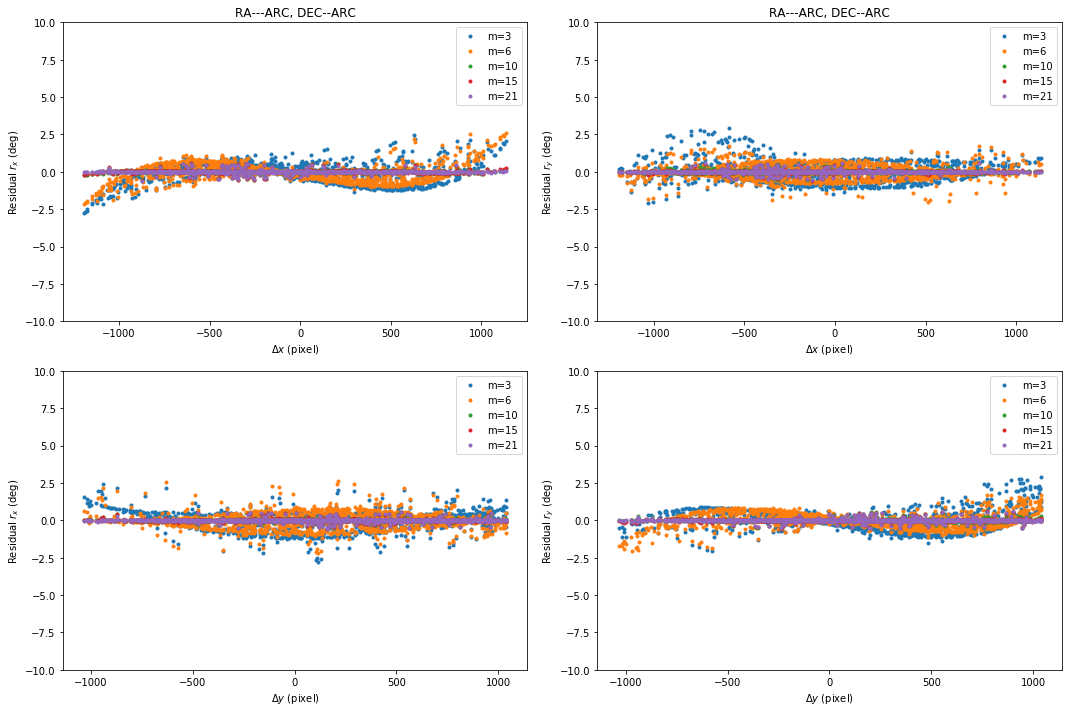

In [9]:
for proj in ["STG", "ZEA", "SIN", "ARC"]:
    w = wcs.WCS(naxis=2)
    w.wcs.ctype = ["RA---%s"%proj, "DEC--%s"%proj]
    w.wcs.cd = [[-1.0, 0.0], [0.0, 1.0]]
    w.wcs.crval = [ra0, dec0]
    w.wcs.crpix = [0.0, 0.0]

    p = w.wcs_world2pix(t["ra"], t["dec"], 1)
    rx, ry = p[0], p[1]

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))


    for m in [3, 6, 10, 15, 21]:
        ax, cov_q, infodict, mesg, ierr = optimize.leastsq(residual, np.zeros(m), args=(dx, dy, rx), full_output=1)
        ay, cov_q, infodict, mesg, ierr = optimize.leastsq(residual, np.zeros(m), args=(dx, dy, ry), full_output=1)
    
        drx, dry = residual(ax, dx, dy, rx), residual(ay, dx, dy, ry)
    
        ax1.plot(dx, drx, ".", label="m=%d"%m)
        ax2.plot(dx, dry, ".", label="m=%d"%m)
        ax3.plot(dy, drx, ".", label="m=%d"%m)
        ax4.plot(dy, dry, ".", label="m=%d"%m)

    ax1.set_xlabel(r"$\Delta x$ (pixel)")
    ax1.set_ylabel(r"Residual $r_x$ (deg)")
    ax2.set_xlabel(r"$\Delta x$ (pixel)")
    ax2.set_ylabel(r"Residual $r_y$ (deg)")
    ax3.set_xlabel(r"$\Delta y$ (pixel)")
    ax3.set_ylabel(r"Residual $r_x$ (deg)")
    ax4.set_xlabel(r"$\Delta y$ (pixel)")
    ax4.set_ylabel(r"Residual $r_y$ (deg)")    

    ax1.set_title("%s, %s" % (w.wcs.ctype[0], w.wcs.ctype[1]))
    ax2.set_title("%s, %s" % (w.wcs.ctype[0], w.wcs.ctype[1]))

    ax1.legend()
    ax2.legend()
    ax3.legend()
    ax4.legend()

    ax1.set_ylim(-10, 10)
    ax2.set_ylim(-10, 10)
    ax3.set_ylim(-10, 10)
    ax4.set_ylim(-10, 10)

    plt.tight_layout()
    plt.savefig("%s.png" % (w.wcs.ctype[0].replace("RA---", "")))

This shows that the ZEA (Zenith Equal Area) projection provides the smallest residuals with the lowest polynomial order.